# Assessing the Impact of Context Inference Error and Partial Observability on RL Methods for Just-In-Time Adaptive Interventions

# <a href="https://colab.research.google.com/github/reml-lab/rl_jitai_simulation/blob/main/examples/rl_jitai_simulation_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an official notebook for the paper **"Assessing the Impact of Context Inference Error and Partial Observability on RL Methods for Just-In-Time Adaptive Interventions"**, accepted at UAI 2023.

**Paper links**: the arXiv version and the published paper links are:

+ [arXiv link](https://arxiv.org/abs/2305.09913)
+ [UAI 2023 link](https://proceedings.mlr.press/v216/karine23a.html)

**Paper abstract**:
Just-in-Time Adaptive Interventions (JITAIs) are a class of personalized health interventions developed within the behavioral science community. JITAIs aim to provide the right type and amount of support by iteratively selecting a sequence of intervention options from a pre-defined set of components in response to each individual's time varying state. In this work, we explore the application of reinforcement learning methods to the problem of learning intervention option selection policies. We study the effect of context inference error and partial observability on the ability to learn effective policies. Our results show that the propagation of uncertainty from context inferences is critical to improving intervention efficacy as context uncertainty increases, while policy gradient algorithms can provide remarkable robustness to partially observed behavioral state information.

**This notebook**: we describe how to use the JITAI Simulation Environment.


# Initialize Code

In [ ]:
!pip install rl_jitai_simulation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from tqdm import tqdm
DASH = '----------------------------------------------------------'

In [ ]:
from RL.rl_jitai_simulation.envs import JITAI_env
from RL.rl_jitai_simulation.agents import ReinforceAgent, DQNAgent

# 1. Introduction

We describe how to use the JITAI Simulation Environment.

## 1.1 How to use the JITAI Simulation Environment

+ JITAI env produces various observations variables (obs). The possible obs names are: ```'C', 'P', 'L', 'H', 'D', 'T'```. These can be set using ```chosen_obs_names```, for example: ```chosen_obs_names=['C','H','D']```, ```['L','H','D']``` or ```['P','T']```, etc., where C is for true contex, P is for probability of context=0, L is for inferred context, H is for habituation, D is for disengagement and T is the binary indicator. Note that all obs samples are augmented by the time inhomogeneous vector, as described in the paper.

+ There are 4 possible actions (action values are: ```0,1,2,3```).

+ JITAI env default parameters are: habituation decay ```δh=0.1```, habituation increment  ```εh=0.05```, disengagement decay ```δd=0.1```, disengagement increment ```εd=0.1```, base reward (for $a_t=1$) ```ρ1=50```, base reward (for $a_t=c_t+2$) ```ρ2=200```. The feature uncertainty ```sigma``` values are: ```0, 0.4,..., 2```.

+ JITAI env is built on top of OpenAI gym environment, and can be plugged in as an Open AI gym environment in an RL loop.

## 1.2 Quickstart: how to use JITAI env, in a simple loop, with random actions

It is very easy to use the JITAI env to simulate trajectories, for example: ```env.get_C()``` can be used to get the current value for the true context ```C```.

env config: obs=C-P-L-H-D-T σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0 D_threshold=1


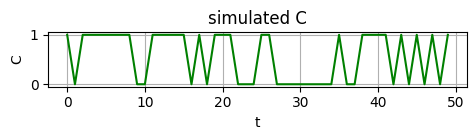

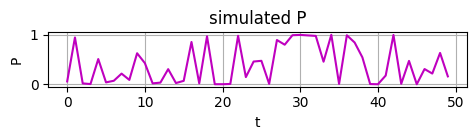

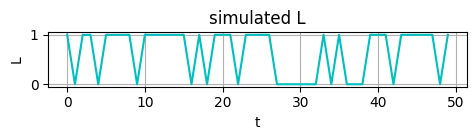

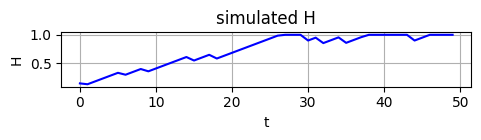

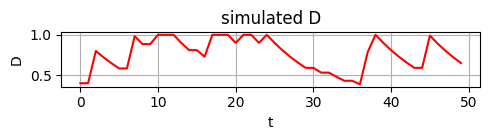

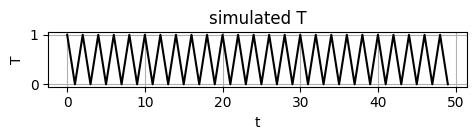

In [ ]:
env = JITAI_env(sigma=0.4, chosen_obs_names=['C', 'P', 'L', 'H', 'D', 'T'],
                δh=0.1, εh=0.05, δd=0.1, εd=0.4, µs=[0.1,0.1], ρ1=50., ρ2=200., ρ3=0, D_threshold=1)

Cs=[]; Ps=[]; Ls=[]; Hs=[]; Ds=[]; Ts=[]
for time_step in range(50):
  action = np.random.choice(4)
  obs_, reward, done, info = env.step(action)
  current_state = env.get_current_state()
  Cs.append(env.get_C())
  Ps.append(env.get_P())
  Ls.append(env.get_L())
  Hs.append(env.get_H())
  Ds.append(env.get_D())
  Ts.append(env.get_T())

def plot_update(title):
  plt.title('simulated '+title)
  plt.xlabel('t'); plt.ylabel(title); plt.tight_layout(); plt.grid(); plt.show()
plt.figure(figsize=(5,1.5)); plt.plot(Cs, color='g'); plot_update('C')
plt.figure(figsize=(5,1.5)); plt.plot(Ps, color='m'); plot_update('P')
plt.figure(figsize=(5,1.5)); plt.plot(Ls, color='c'); plot_update('L')
plt.figure(figsize=(5,1.5)); plt.plot(Hs, color='b'); plot_update('H')
plt.figure(figsize=(5,1.5)); plt.plot(Ds, color='r'); plot_update('D')
plt.figure(figsize=(5,1.5)); plt.plot(Ts, color='k'); plot_update('T')

## 1.3 Quickstart: how to use JITAI env, in an RL loop

It is very easy to use the JITAI env:
1. Instantiate the JITAI env, with desired sigma (sigma is the context uncertainty as described in the paper)
2. Call env.reset()
3. Call env.step(action) in a loop

### 1.3.1 Code to run RL loop for DQN and REINFORCE

In [ ]:
def run_RL_loop_DQN(env, agent, n_episodes, b_train, b_plot=False, plot_title='', y_lim=(-200,3500)):
  return_values = []
  for i in tqdm(range(n_episodes), desc ="DQN {} σ={} duration".format(env.chosen_obs_names_str, env.sigma)):
    obs = env.reset()
    return_value = 0
    done = False
    while not done:
      action = agent.choose_action(obs)
      obs_, reward, done, info = env.step(action)
      agent.observe(obs, action, reward, obs_, done)
      if b_train: agent.update()
      obs = obs_
      return_value += reward
    return_values.append(return_value)
  if b_plot:
    plt.figure(figsize=(3,2))
    plt.plot(return_values)
    if len(plot_title) < 1:
      plot_title = ' (σ={})'.format(env.sigma)
    plt.title('DQN {} learning{}'.format(env.chosen_obs_names_str, plot_title))
    plt.ylim(y_lim); plt.xlabel('episode'); plt.ylabel('return'); plt.grid(); plt.show()
  return return_values

def run_RL_loop_REINFORCE(env, agent, M, n_episodes, b_train, b_plot=False, plot_title='', y_lim=(-200,3500)):
  return_values = []
  for i in tqdm(range(n_episodes), desc ="REINFORCE {} σ={} duration".format(env.chosen_obs_names_str, env.sigma)):
    if b_train: agent.init_grad()
    return_samples = []
    for m in range(M):
      obs = env.reset()
      return_sample = 0
      done = False
      while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_rewards(reward)
        obs = obs_
        return_sample += reward
      return_samples.append(return_sample)
      if b_train: agent.compute_grad()
    if b_train: agent.take_step(env.max_episode_length)
    return_values.append(np.mean(return_samples))
  if b_plot:
    plt.figure(figsize=(3,2))
    plt.plot(return_values)
    if len(plot_title) < 1:
      plot_title = ' (σ={})'.format(env.sigma)
    plt.title('REINFORCE {} learning{}'.format(env.chosen_obs_names_str, plot_title))
    plt.ylim(y_lim); plt.xlabel('episode'); plt.ylabel('return'); plt.grid(); plt.show()
  return return_values

def set_random_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)

def  get_key(sigma, δd, εd, seed, chosen_obs_name):
  str_detail = 'σ={} δd={} εd={} seed={} obs={}'.format(sigma, δd, εd, seed, '-'.join(chosen_obs_name))
  str_key = str_detail.replace('.','').replace(' ','_').replace('-','').replace('=','')
  return str_key

### 1.3.2 Quickstart: how to use JITAI env, in an RL loop, using DQN (dueling DQN)

env config: obs=C-H-D σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


DQN C-H-D σ=0.4 duration: 100%|██████████| 250/250 [00:41<00:00,  6.00it/s]


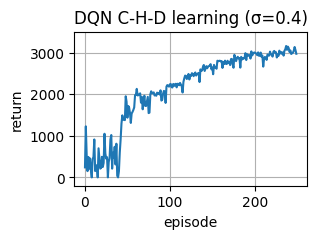

In [ ]:
set_random_seed(0)
env = JITAI_env(sigma=0.4, chosen_obs_names=['C', 'H', 'D'])
agent = DQNAgent(gamma=1, lr=5e-4, batch_size=64, input_dims=[env.get_obs_length()], n_actions=4, fc1_dim=128, fc2_dim=128)
return_values = run_RL_loop_DQN(env, agent, n_episodes=250, b_train=True, b_plot=True)

### 1.3.3 Quickstart: how to use JITAI env, in an RL loop, using REINFORCE

env config: obs=C-H-D σ=0.4 δh=0.1 εh=0.05 δd=0.1 εd=0.4 µs=[0.1, 0.1] ρ1=50.0 ρ2=200.0 ρ3=0.0 D_threshold=1


REINFORCE C-H-D σ=0.4 duration: 100%|██████████| 5000/5000 [22:30<00:00,  3.70it/s]


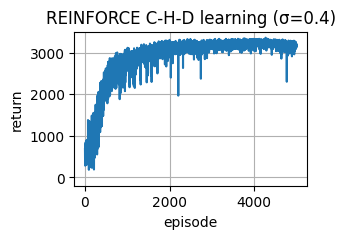

In [ ]:
set_random_seed(0)
env = JITAI_env(sigma=0.4, chosen_obs_names=['C', 'H', 'D'])
agent = ReinforceAgent(gamma=1, lr=6e-4, input_dims=[env.get_obs_length()], n_actions=4, fc1_dim=128, fc2_dim=None)
return_values = run_RL_loop_REINFORCE(env, agent, M=3, n_episodes=5000, b_train=True, b_plot=True)